# Relate Error:
There seems to be a problem with the shapley.relates function. It is not returning the correct relationship between the two polygons.

## Setup

### Imports

In [1]:
from math import radians, cos, sin
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely.plotting import plot_polygon, plot_line


In [2]:
%matplotlib inline

In [3]:
PRECISION = 3


In [4]:
def circle_points(radius: float, offset_x: float = 0, offset_y: float = 0,
                  num_points: int = 16, precision=PRECISION,
                  z:float=None)->list[tuple[float, float]]:
    deg_step = radians(360/num_points)
    degree_points = np.arange(stop=radians(360), step=deg_step)
    if radius == 0:
        radius = 10**(-precision)
    x_coord = np.array([round(radius*sin(d), precision) for d in degree_points])
    y_coord = np.array([round(radius*cos(d), precision) for d in degree_points])
    x_coord = x_coord + offset_x
    y_coord = y_coord + offset_y
    if z is not None:
        z = float(z)
        coords = [(x,y,z) for x,y in zip(x_coord,y_coord)]
    else:
        coords = list(zip(x_coord,y_coord))
    return coords

In [5]:
def plot_ab(poly_a, poly_b):
    def plot_geom(ax, geom, color='black'):
        if isinstance(geom, (shapely.Polygon, shapely.MultiPolygon)):
            plot_polygon(geom, ax=ax, add_points=False, color=color, facecolor=color)
        elif isinstance(geom, (shapely.LineString, shapely.MultiLineString,
                               shapely.LinearRing, shapely.LinearRing)):
            plot_line(geom, ax=ax, add_points=False, color=color)
        elif isinstance(geom, shapely.GeometryCollection):
            # plot each of the geometry objects in the collection
            for g in geom.geoms:
                plot_geom(ax, g, color)

    fig = plt.figure(1, figsize=(4,2))
    ax = fig.add_subplot(121)
    ax.set_axis_off()
    ax.axis('equal')

    only_a = shapely.difference(poly_a, poly_b)
    plot_geom(ax, only_a, color='blue')
    only_b = shapely.difference(poly_b, poly_a)
    plot_geom(ax, only_b, color='green')
    both_ab = shapely.intersection(poly_a, poly_b)
    plot_geom(ax, both_ab, color='orange')

    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    plt.show()
    return ax

In [6]:
circle6 = shapely.Polygon(circle_points(3))
circle4_offset = shapely.Polygon(circle_points(2, offset_x=2))
cropped_circle = shapely.intersection(circle6, circle4_offset)


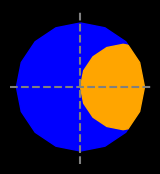

In [7]:
ax = plot_ab(circle6, cropped_circle)

In [8]:
circle6.relate(cropped_circle)

'212111212'

`'212111212'` is a rather odd relationship code. 
It says that the two polygons both have parts that are exterior to the other, but the difference between cropped_circle and circle6 is an empty polygon.

In [9]:
dif = cropped_circle - circle6
dif.area


0.0

In [10]:
shapely.get_coordinates(dif).tolist()

[]

In [11]:
cropped_circle.relate(circle6)

'212111212'

The transposed relation produces the same result, which is also incorrect.

## First guess is a rounding error

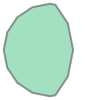

In [12]:
simplified = shapely.simplify(cropped_circle, 10**-PRECISION)
simplified

In [13]:
circle6.relate(simplified)

'212111212'

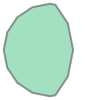

In [14]:
snapped = shapely.snap(cropped_circle, circle6, 10**-PRECISION)
snapped

In [15]:
circle6.relate(snapped)

'212111212'

In [16]:
simplified = shapely.simplify(cropped_circle, 10**-2)
circle6.relate(simplified)

'212111212'

In [17]:
snapped = shapely.snap(cropped_circle, circle6, 10**-2)
circle6.relate(snapped)

'212111212'

## If precision is set to 2, the result is correct

In [18]:
circle6 = shapely.Polygon(circle_points(3, precision=2))
circle4_offset = shapely.Polygon(circle_points(2, offset_x=2, precision=2))
cropped_circle = shapely.intersection(circle6, circle4_offset)

circle6.relate(cropped_circle)

'212F11FF2'

## Try removing the rounding using `simplify` or `snap`

In [19]:
def circle_points_no_round(radius: float,
                           offset_x: float = 0, offset_y: float = 0,
                           num_points: int = 16)->list[tuple[float, float]]:
    deg_step = radians(360/num_points)
    degree_points = np.arange(stop=radians(360), step=deg_step)
    x_coord = np.array([radius*sin(d) for d in degree_points])
    y_coord = np.array([radius*cos(d) for d in degree_points])
    x_coord = x_coord + offset_x
    y_coord = y_coord + offset_y
    coords = list(zip(x_coord,y_coord))
    return coords

In [20]:
circle6 = shapely.Polygon(circle_points_no_round(3))
circle4_offset = shapely.Polygon(circle_points_no_round(2, offset_x=2))
cropped_circle = shapely.intersection(circle6, circle4_offset)

circle6.relate(cropped_circle)

'212111212'

In [21]:
simplified = shapely.simplify(cropped_circle, 10**-2)
circle6.relate(simplified)

'212111212'

In [22]:
snapped = shapely.snap(cropped_circle, circle6, 10**-2)
circle6.relate(snapped)

'212111212'